# Data Mining Final Project : H-1B Visa Petitions 2011-2016 

## Part 1: EDA + Data Cleaning

## Team members:
* Hangqi Liu 
* Yixiao Yang 
* Akhil Ranjan 
* Jianghong Man 
* Yuge Li
* Ziqing Wang

### In this session we did:
* Geospatial implementation
* Basic info of the dataset (missing values + unique values)
* EDA + cleaning + feature selection for each variable

### Data description:
* CASE_STATUS: Status associated with the last significant event or decision. Valid values include “Certified,” “Certified-Withdrawn,” Denied,” and “Withdrawn”.
* EMPLOYER_NAME: Name of employer submitting labor condition application
* SOC_NAME: Occupational name associated with the SOC_CODE. SOC_CODE is the occupational code associated with the job being requested for temporary labor conditions, as classified by the Standard Occupational Classification (SOC) System
* JOB_TITLE: Title of the job
* FULL_TIME_POSITION: Y = Full Time Position; N = Part Time Position
* PREVAILING_WAGE: Prevailing Wage for the job being requested for temporary labor condition. The wage is listed at annual scale in USD. The prevailing wage for a job position is defined as the average wage paid to similarly employed workers in the requested occupation in the area of intended employment. The prevailing wage is based on the employer’s minimum requirements for the position
* YEAR: Year in which the H-1B visa petition was filed
* WORKSITE: City and State information of the foreign worker’s intended area of employment
* lon: longitude of the Worksite
* lat: latitude of the Worksite

# Import packages

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import math
import csv
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import FastMarkerCluster, MarkerCluster

import geopandas as gpd
from geopy.geocoders import Nominatim 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import re
import sklearn
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import sklearn.cluster
import distance

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

# Geospatial implementation

In [2]:
df = pd.read_csv('h1b_kaggle.csv')
df.drop(['Unnamed: 0'],inplace = True,axis = 1)
df.head()

,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
0,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016.0,"ANN ARBOR, MICHIGAN",-83.743038,42.280826
1,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,242674.0,2016.0,"PLANO, TEXAS",-96.698886,33.019843
2,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,Y,193066.0,2016.0,"JERSEY CITY, NEW JERSEY",-74.077642,40.728158
3,CERTIFIED-WITHDRAWN,"GATES CORPORATION, A WHOLLY-OWNED SUBSIDIARY O...",CHIEF EXECUTIVES,"REGIONAL PRESIDEN, AMERICAS",Y,220314.0,2016.0,"DENVER, COLORADO",-104.990251,39.739236
4,WITHDRAWN,PEABODY INVESTMENTS CORP.,CHIEF EXECUTIVES,PRESIDENT MONGOLIA AND INDIA,Y,157518.4,2016.0,"ST. LOUIS, MISSOURI",-90.199404,38.627003


In [3]:
df.shape

(3002458, 10)

In [ ]:
df_map = df.copy()
df_map = df_map.dropna()

lats = df_map['lat'].tolist()
lons = df_map['lon'].tolist()
locations = list(zip(lats, lons))

map_USA = folium.Map(location=[52.3680, 4.9036], zoom_start=11.5)
FastMarkerCluster(data=locations).add_to(map_USA)
map_USA

### Unsupervised clustering: kmeans analysis of lon, lat

In [2]:
df_loc = df.copy()
df_loc = df_loc.dropna()

X = df_loc.loc[-3000:,['Unnamed: 0','lat','lon']]
X.head(10)

,Unnamed: 0,lat,lon
0,1,42.280826,-83.743038
1,2,33.019843,-96.698886
2,3,40.728158,-74.077642
3,4,39.739236,-104.990251
4,5,38.627003,-90.199404
5,6,25.761680,-80.191790
6,7,29.760427,-95.369803
7,8,37.338208,-121.886329
9,10,38.901222,-77.265260
10,11,40.440625,-79.995886


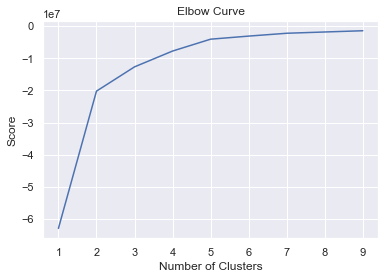

In [3]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = df_loc[['lat']]
X_axis = df_loc[['lon']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [4]:
kmeans = KMeans(n_clusters = 2, init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point
X.head(10)

,Unnamed: 0,lat,lon,cluster_label
0,1,42.280826,-83.743038,0
1,2,33.019843,-96.698886,0
2,3,40.728158,-74.077642,0
3,4,39.739236,-104.990251,1
4,5,38.627003,-90.199404,0
5,6,25.761680,-80.191790,0
6,7,29.760427,-95.369803,0
7,8,37.338208,-121.886329,1
9,10,38.901222,-77.265260,0
10,11,40.440625,-79.995886,0


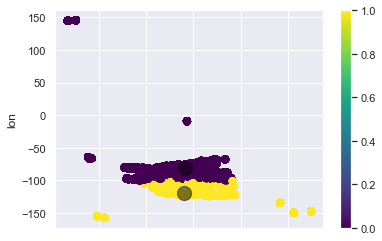

In [5]:
X.plot.scatter(x = 'lat', y = 'lon', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

# Basic info

In [9]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [333]:
missing_data(df)

,Unnamed: 0,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
Total,0,13,59,17734,43,15,85,13,0,107242,107242
Percent,0,0.000432979,0.00196506,0.590649,0.00143216,0.000499591,0.00283101,0.000432979,0,3.57181,3.57181
Types,int64,object,object,object,object,object,float64,float64,object,float64,float64


In [4]:
print('shape before dropna:', df.shape)
df.dropna(subset=['CASE_STATUS','EMPLOYER_NAME','JOB_TITLE','FULL_TIME_POSITION','PREVAILING_WAGE','YEAR'], 
          inplace=True)
print('shape after dropna:', df.shape)

shape before dropna: (3002458, 10)
shape after dropna: (3002311, 10)


In [335]:
def unique_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    uniques = []
    for col in data.columns:
        unique = data[col].nunique()
        uniques.append(unique)
    tt['Uniques'] = uniques
    return(np.transpose(tt))

In [336]:
unique_values(df)

,Unnamed: 0,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
Total,3002311,3002311,3002311,2984609,3002311,3002311,3002311,3002311,3002311,2895091,2895091
Uniques,3002311,7,236003,2131,287540,2,56156,6,18604,2404,2406


# EDA + Data cleaning by variables

In [6]:
def plot_count(feature, title, df, size=1, ordered=True):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    if ordered:
        g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette='Set2')
    else:
        g = sns.countplot(df[feature], palette='Set2')
    g.set_title("Number and percentage of {}".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show() 

### CASE_STATUS

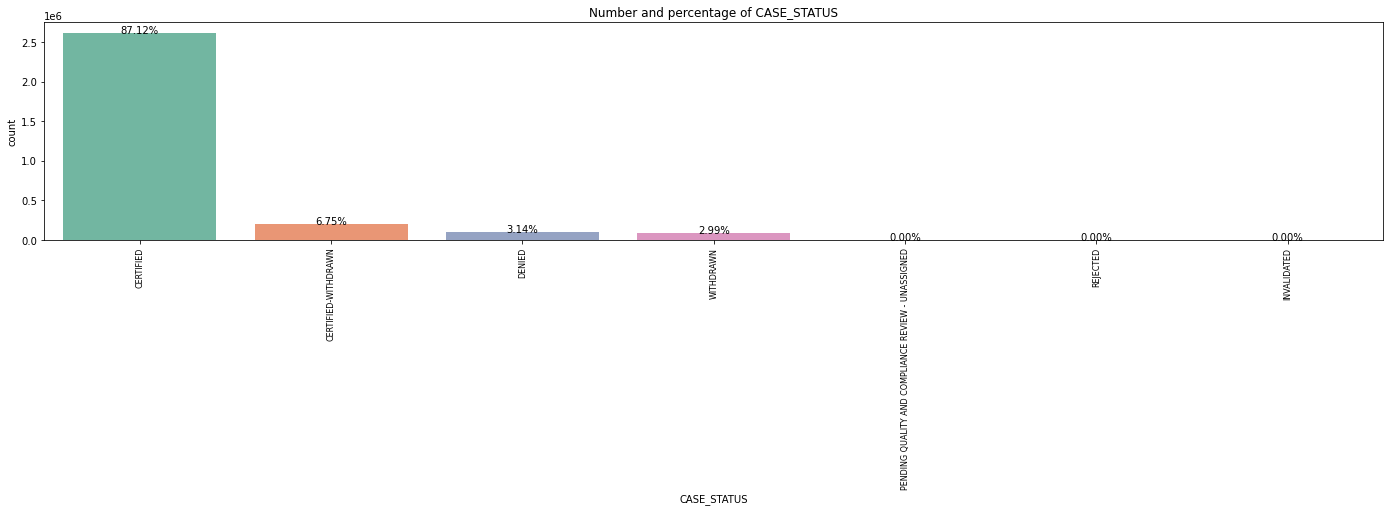

In [339]:
plot_count("CASE_STATUS", "CASE_STATUS", df,6)

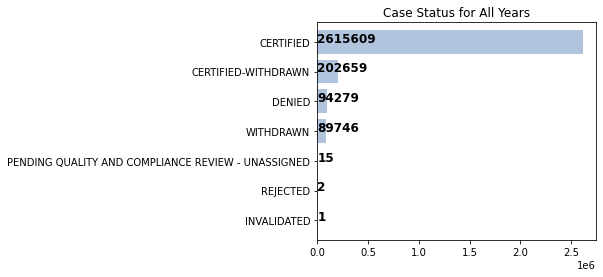

In [340]:
plt.figure(figsize=(5,4))
ax = df['CASE_STATUS'].value_counts().sort_values(ascending=True).plot.barh(width=0.8,color='lightsteelblue')
for i, v in enumerate(df['CASE_STATUS'].value_counts().sort_values(ascending=True).values): 
    ax.text(.6, i, v,fontsize=12,weight='bold')
plt.title('Case Status for All Years')
plt.show()

In [30]:
df.CASE_STATUS[df['CASE_STATUS']=='CERTIFIED-WITHDRAWN'] = 'CERTIFIED'
df = df.drop(df[df.CASE_STATUS == 'WITHDRAWN'].index)
df.CASE_STATUS[df['CASE_STATUS']=='PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED'] = 'DENIED'
df.CASE_STATUS[df['CASE_STATUS']=='REJECTED'] = 'DENIED'
df.CASE_STATUS[df['CASE_STATUS']=='INVALIDATED'] = 'DENIED'

In [31]:
df["CASE_STATUS"].unique()

array(['CERTIFIED', 'DENIED'], dtype=object)

### EMPLOYER_NAME

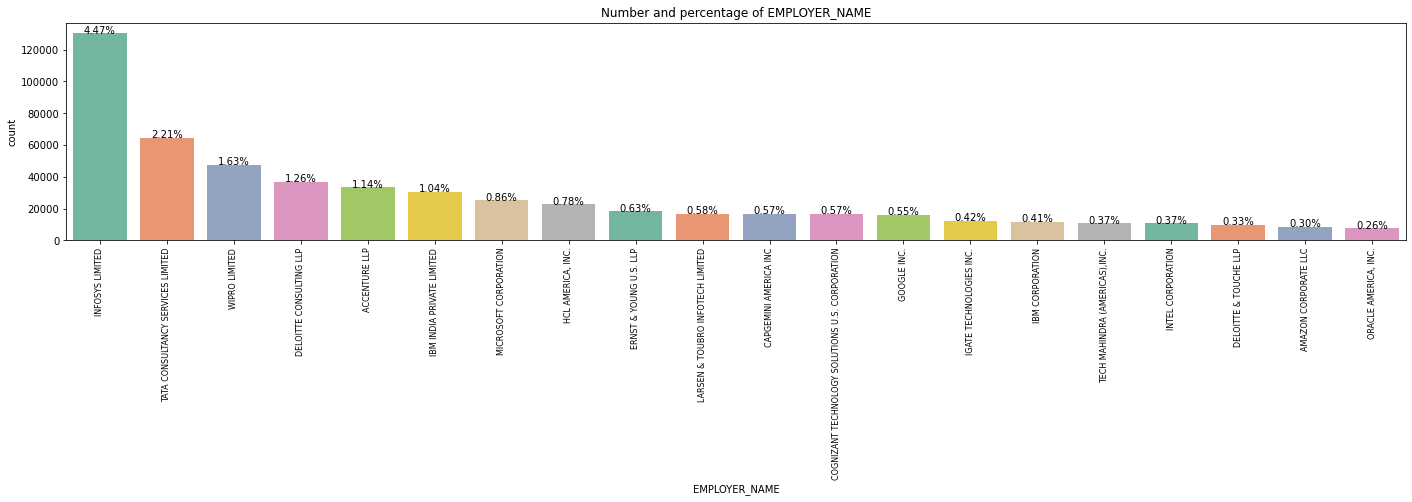

In [343]:
plot_count("EMPLOYER_NAME", "EMPLOYER_NAME", df,6)

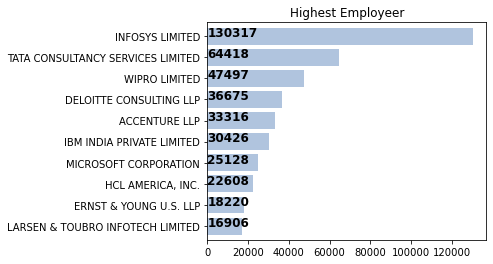

In [344]:
plt.figure(figsize=(5,4))

ax = df['EMPLOYER_NAME'].value_counts().sort_values(ascending=False)[:10].plot.barh(width=0.8,color='lightsteelblue')
for i, v in enumerate(df['EMPLOYER_NAME'].value_counts().sort_values(ascending=False).values[:10]): 
    ax.text(.6, i, v,fontsize=12,weight='bold')
plt.title('Highest Employeer')
fig = plt.gca()
fig.invert_yaxis()
plt.show()

In [24]:
# Choose first 1000 employeers and change them to categorical value
df['EMPLOYER_NAME'] = df['EMPLOYER_NAME'].str.upper()
top1000_emp = list(df['EMPLOYER_NAME']
                   .groupby(df['EMPLOYER_NAME']).count().sort_values(ascending=False).head(1000).index)

df.loc[~df["EMPLOYER_NAME"].isin(top1000_emp), "EMPLOYER_NAME"] = "Others"

In [25]:
top1000_emp

['INFOSYS LIMITED',
 'TATA CONSULTANCY SERVICES LIMITED',
 'WIPRO LIMITED',
 'DELOITTE CONSULTING LLP',
 'IBM INDIA PRIVATE LIMITED',
 'ACCENTURE LLP',
 'MICROSOFT CORPORATION',
 'HCL AMERICA, INC.',
 'ERNST & YOUNG U.S. LLP',
 'COGNIZANT TECHNOLOGY SOLUTIONS U.S. CORPORATION',
 'LARSEN & TOUBRO INFOTECH LIMITED',
 'CAPGEMINI AMERICA INC',
 'GOOGLE INC.',
 'IBM CORPORATION',
 'IGATE TECHNOLOGIES INC.',
 'INTEL CORPORATION',
 'TECH MAHINDRA (AMERICAS),INC.',
 'DELOITTE & TOUCHE LLP',
 'AMAZON CORPORATE LLC',
 'ORACLE AMERICA, INC.',
 'APPLE INC.',
 'JPMORGAN CHASE & CO.',
 'TECH MAHINDRA (AMERICAS), INC.',
 'UST GLOBAL INC.',
 'UST GLOBAL INC',
 'QUALCOMM TECHNOLOGIES, INC.',
 'HEXAWARE TECHNOLOGIES, INC.',
 'FUJITSU AMERICA, INC.',
 'MASTECH, INC., A MASTECH HOLDINGS, INC. COMPANY',
 'MPHASIS CORPORATION',
 'CUMMINS INC.',
 'KPMG LLP',
 'NTT DATA, INC.',
 'EMC CORPORATION',
 'CAPGEMINI FINANCIAL SERVICES USA INC',
 'V-SOFT CONSULTING GROUP, INC',
 'BANK OF AMERICA N.A.',
 'FACEBOOK, IN

### SOC_NAME

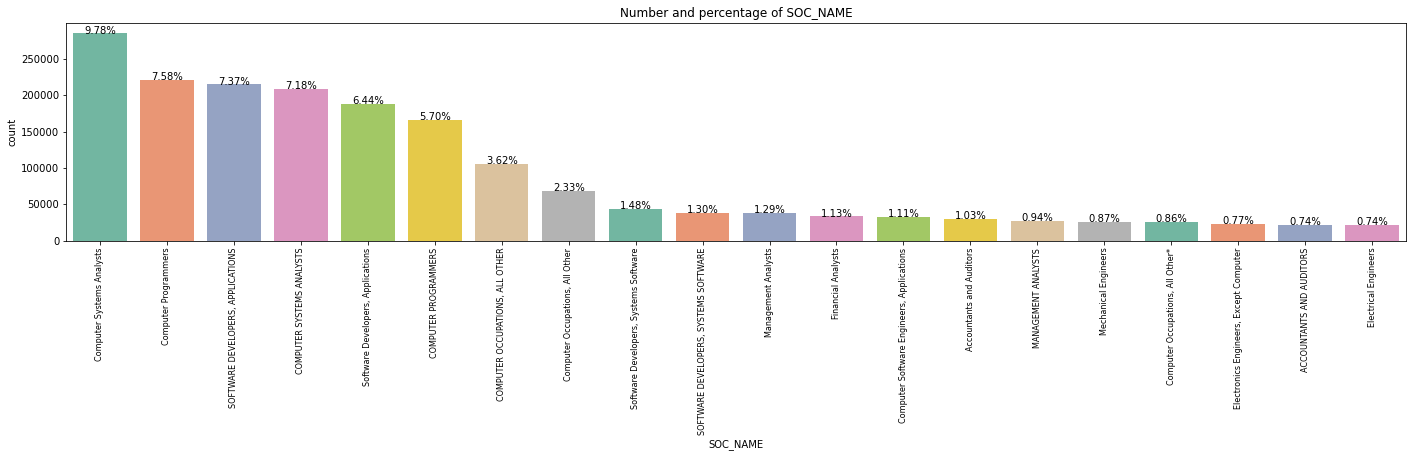

In [348]:
plot_count("SOC_NAME", "SOC_NAME", df,6)

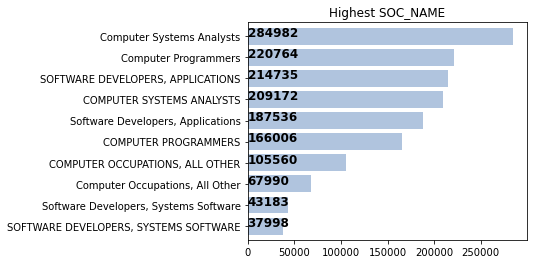

In [349]:
plt.figure(figsize=(5,4))

ax = df['SOC_NAME'].value_counts().sort_values(ascending=False)[:10].plot.barh(width=0.8,color='lightsteelblue')
for i, v in enumerate(df['SOC_NAME'].value_counts().sort_values(ascending=False).values[:10]): 
    ax.text(.6, i, v,fontsize=12,weight='bold')
plt.title('Highest SOC_NAME')
fig = plt.gca()
fig.invert_yaxis()
plt.show()

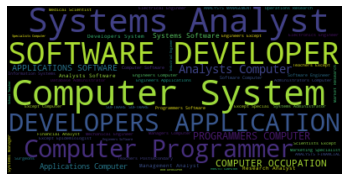

In [7]:
text =  " ".join(SOC_NAME for SOC_NAME in df.SOC_NAME)

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [26]:
print('original df shape:', df.shape)
print('soc name is null:',df.SOC_NAME.isnull().sum())
df1 = df[df['SOC_NAME'].isnull()]
df.dropna(subset=['SOC_NAME'], inplace=True)
print('after drop null soc name:',df.shape)

df1['JOB_TITLE'] = df1['JOB_TITLE'].str.lower()
df1['SOC_NAME1'] = 'others'
df1['SOC_NAME1'][df1['JOB_TITLE'].str.contains('director','managing')] = 'manager'
df1['SOC_NAME1'][df1['JOB_TITLE'].str.contains('manager')] = 'manager'
df1['SOC_NAME1'][df1['JOB_TITLE'].str.contains('programmers','programmer')] = 'it'
df1['SOC_NAME1'][df1['JOB_TITLE'].str.contains('computer','system')] = 'it'
df1['SOC_NAME1'][df1['JOB_TITLE'].str.contains('software','systems')] = 'it'
df1['SOC_NAME1'][df1['JOB_TITLE'].str.contains('developer')] = 'it'
df1['SOC_NAME1'][df1['JOB_TITLE'].str.contains('physician')] = 'medical'
df1['SOC_NAME1'][df1['JOB_TITLE'].str.contains('financial','business')] = 'finance'
df1['SOC_NAME1'][df1['JOB_TITLE'].str.contains('mechanical','biologist')] = 'mechanical'
df1['SOC_NAME1'][df1['JOB_TITLE'].str.contains('forencsic','health')] = 'medical'
df1['SOC_NAME1'][df1['JOB_TITLE'].str.contains('database','data')] = 'data'
df1['SOC_NAME1'][df1['JOB_TITLE'].str.contains('engineer')] = 'engineer'
df1['SOC_NAME1'][df1['JOB_TITLE'].str.contains('analyst')] = 'analyst'
df1['SOC_NAME1'][df1['JOB_TITLE'].str.contains('research')] = 'research'
df1['SOC_NAME1'][df1['JOB_TITLE'].str.contains('sales','market')] = 'scm'
df1['SOC_NAME1'][df1['JOB_TITLE'].str.contains('sale','logistic')] = 'scm'
df1['SOC_NAME1'][df1['JOB_TITLE'].str.contains('law')] = 'administrative'
df1['SOC_NAME1'][df1['JOB_TITLE'].str.contains('auditor','compliance')] = 'audit'
df1['SOC_NAME1'][df1['JOB_TITLE'].str.contains('recruiter','human')] = 'hr'
df1['SOC_NAME1'][df1['JOB_TITLE'].str.contains('construction','architecture')] = 'estate'
df1['SOC_NAME1'][df1['JOB_TITLE'].str.contains('teacher','education')] = 'education'

df1['SOC_NAME1'] = df1.SOC_NAME1.astype('category')

original df shape: (3002311, 12)
soc name is null: 17702
after drop null soc name: (2984609, 12)


In [27]:
df['SOC_NAME'] = df['SOC_NAME'].str.upper()

df['SOC_NAME'] = df['SOC_NAME'].fillna(df['SOC_NAME'].mode()[0])

df['SOC_NAME1'] = 'others'
df['SOC_NAME1'][df['SOC_NAME'].str.contains('computer','software')] = 'it'
df['SOC_NAME1'][df['SOC_NAME'].str.contains('chief','management')] = 'manager'
df['SOC_NAME1'][df['SOC_NAME'].str.contains('mechanical')] = 'mechanical'
df['SOC_NAME1'][df['SOC_NAME'].str.contains('database')] = 'database'
df['SOC_NAME1'][df['SOC_NAME'].str.contains('sales','market')] = 'scm'
df['SOC_NAME1'][df['SOC_NAME'].str.contains('financial')] = 'finance'
df['SOC_NAME1'][df['SOC_NAME'].str.contains('public','fundraising')] = 'pr'
df['SOC_NAME1'][df['SOC_NAME'].str.contains('education','law')] = 'administrative'
df['SOC_NAME1'][df['SOC_NAME'].str.contains('auditors','compliance')] = 'audit'
df['SOC_NAME1'][df['SOC_NAME'].str.contains('distribution','logistics')] = 'scm'
df['SOC_NAME1'][df['SOC_NAME'].str.contains('recruiters','human')] = 'hr'
df['SOC_NAME1'][df['SOC_NAME'].str.contains('agricultural','farm')] = 'agri'
df['SOC_NAME1'][df['SOC_NAME'].str.contains('construction','architectural')] = 'estate'
df['SOC_NAME1'][df['SOC_NAME'].str.contains('forencsic','health')] = 'medical'
df['SOC_NAME1'][df['SOC_NAME'].str.contains('teachers')] = 'education'

In [28]:
frames = [df, df1]
df = pd.concat(frames)
print(df.shape)

(3002311, 13)


In [33]:
df = df.drop(['SOC_NAME'], axis = 1)

### JOB_TITLE

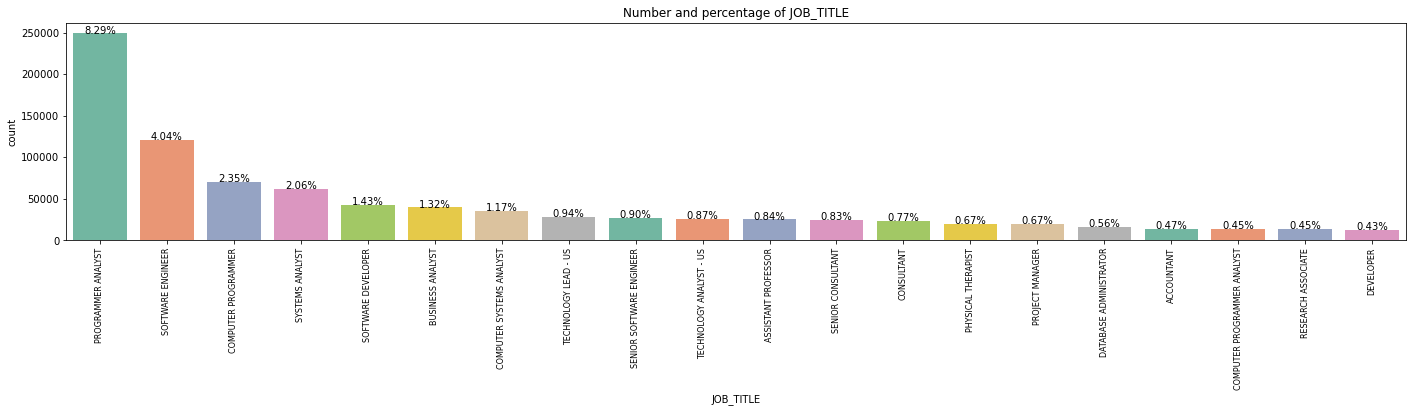

In [7]:
plot_count("JOB_TITLE", "JOB_TITLE", df,6)

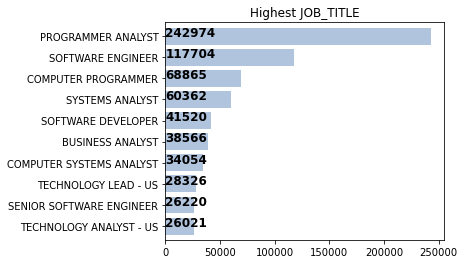

In [351]:
plt.figure(figsize=(5,4))

ax = df['JOB_TITLE'].value_counts().sort_values(ascending=False)[:10].plot.barh(width=0.8,color='lightsteelblue')
for i, v in enumerate(df['JOB_TITLE'].value_counts().sort_values(ascending=False).values[:10]): 
    ax.text(.6, i, v,fontsize=12,weight='bold')
plt.title('Highest JOB_TITLE')
fig = plt.gca()
fig.invert_yaxis()
plt.show()

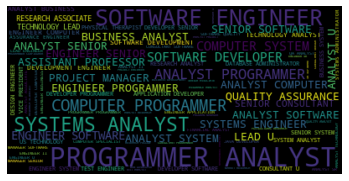

In [8]:
text =  " ".join(JOB_TITLE for JOB_TITLE in df.JOB_TITLE)

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [11]:
df["JOB_TITLE_lower"] = df.JOB_TITLE.str.lower()

In [17]:
embedder = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

100%|██████████| 245M/245M [00:50<00:00, 4.86MB/s] 


In [18]:
JOB_TITLE_lower = df['JOB_TITLE_lower'].values
JOB_TITLE_lower_embeddings = embedder.encode(JOB_TITLE_lower)

In [19]:
num_clusters = 20
# Define kmeans model
clustering_model = KMeans(n_clusters=num_clusters)
# Fit the embedding with kmeans clustering.
clustering_model.fit(JOB_TITLE_lower_embeddings)
# Get the cluster id assigned to each news headline.
cluster_assignment = clustering_model.labels_

In [20]:
print(cluster_assignment)

[18  8  8 ... 15  9  9]


In [22]:
df["cluster_job_title"] = cluster_assignment

In [36]:
df = df.drop(['JOB_TITLE', 'JOB_TITLE_lower'], axis = 1)

### FULL_TIME_POSITION

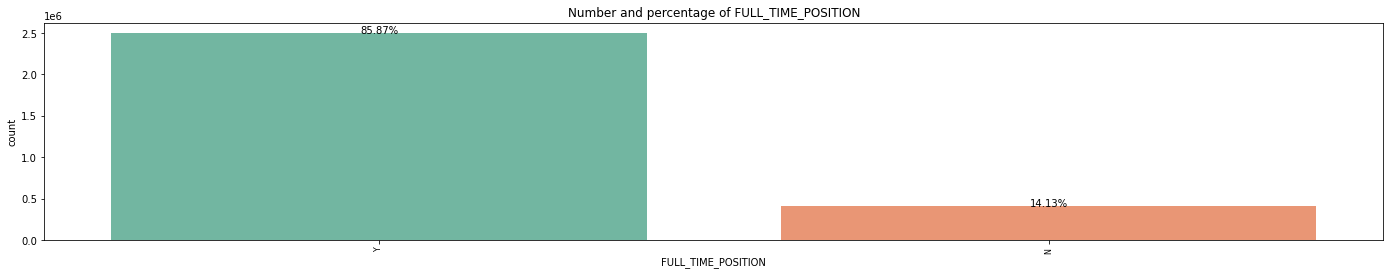

In [38]:
plot_count("FULL_TIME_POSITION", "FULL_TIME_POSITION", df,6)

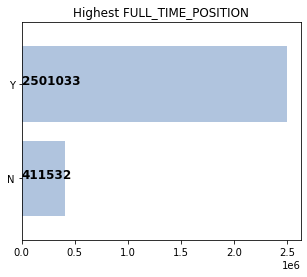

In [39]:
plt.figure(figsize=(5,4))

ax = df['FULL_TIME_POSITION'].value_counts().sort_values(ascending=False)[:10].plot.barh(width=0.8,color='lightsteelblue')
for i, v in enumerate(df['FULL_TIME_POSITION'].value_counts().sort_values(ascending=False).values[:10]): 
    ax.text(.6, i, v,fontsize=12,weight='bold')
plt.title('Highest FULL_TIME_POSITION')
fig = plt.gca()
fig.invert_yaxis()
plt.show()

### PREVAILING_WAGE

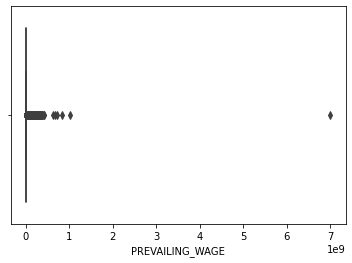

In [40]:
sns.boxplot(x=df['PREVAILING_WAGE'])

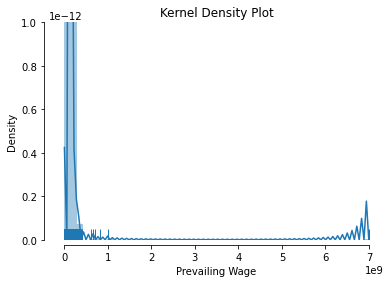

In [41]:
# Wage KDE
ax = sns.distplot(df['PREVAILING_WAGE'], kde=True, rug=True)
ax.set_xlabel('Prevailing Wage')
ax.set_ylabel('Density')
ax.set_title('Kernel Density Plot')
sns.despine(offset=5, trim=True)

In [42]:
Q1 = df.PREVAILING_WAGE.quantile(0.25)
Q3 = df.PREVAILING_WAGE.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

27019.0


In [43]:
df = df.loc[df['PREVAILING_WAGE'] >= (Q1 - 1.5 * IQR)]
df = df.loc[df['PREVAILING_WAGE'] <= (Q3 + 1.5 * IQR)]

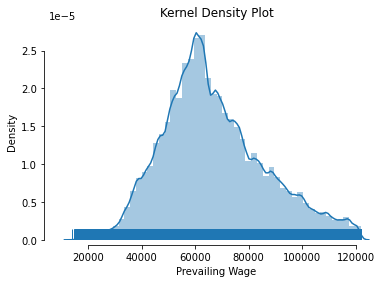

In [44]:
ax = sns.distplot(df['PREVAILING_WAGE'], kde=True, rug=True)
ax.set_xlabel('Prevailing Wage')
ax.set_ylabel('Density')
ax.set_title('Kernel Density Plot')
sns.despine(offset=5, trim=True)

### YEAR

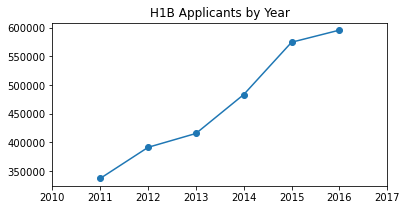

In [45]:
plt.figure(figsize=(6,3))
df['YEAR'].value_counts().sort_values().plot(marker='o')
plt.title('H1B Applicants by Year')
plt.xlim([2010,2017])
plt.show()

### WORKSITE

#### Create the State column 

In [47]:
state_split = df["WORKSITE"].str.split(', ', n = 1, expand = True) 
df["State"]= state_split[1] 

In [49]:
df = df.drop(['WORKSITE'], axis = 1)

#### Drop lon and lat to avoid duplicated information

In [50]:
df = df.drop(['lon', 'lat'], axis = 1)

# Semi-final df

In [51]:
df.head()

,CASE_STATUS,EMPLOYER_NAME,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,cluster_job_title,SOC_NAME1,State
0,CERTIFIED,UNIVERSITY OF MICHIGAN,N,36067.0,2016.0,18,others,MICHIGAN
6,CERTIFIED,Others,Y,91021.0,2016.0,8,others,TEXAS
14,CERTIFIED,Others,Y,105914.0,2016.0,13,others,COLORADO
16,CERTIFIED,Others,Y,90834.0,2016.0,12,others,WISCONSIN
20,CERTIFIED,Others,Y,117998.0,2016.0,8,others,CALIFORNIA


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2799076 entries, 0 to 3002212
Data columns (total 8 columns):
 #   Column              Dtype  
---  ------              -----  
 0   CASE_STATUS         object 
 1   EMPLOYER_NAME       object 
 2   FULL_TIME_POSITION  object 
 3   PREVAILING_WAGE     float64
 4   YEAR                float64
 5   cluster_job_title   int32  
 6   SOC_NAME1           object 
 7   State               object 
dtypes: float64(2), int32(1), object(5)
memory usage: 181.5+ MB


# EDA after cleaning 

In [56]:
df_after_clean = df.copy()

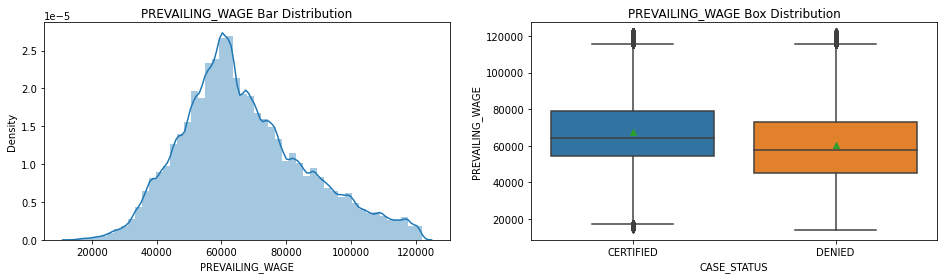

In [58]:
numeric_col = np.array(['PREVAILING_WAGE'])

# add bar&box plot for each numeric variable 
for column in numeric_col:
    # set the figure size 
    plt.figure(figsize=(16,4))
    
    # draw the bar chart
    plt.subplot(1,2,1)
    sns.distplot(df[column])
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.title(f'{column} Bar Distribution')
    
    # draw the box chart, group by "y"
    plt.subplot(1,2,2)
    sns.boxplot(x='CASE_STATUS', y=column, data =df_after_clean, showmeans=True )
    plt.xlabel('CASE_STATUS')
    plt.ylabel(column)
    plt.title(f'{column} Box Distribution')

    plt.show()
    print()

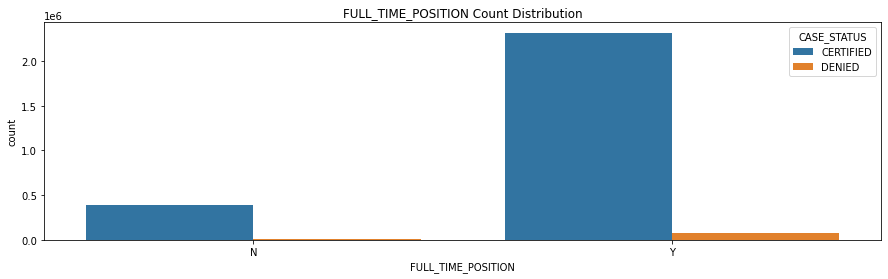

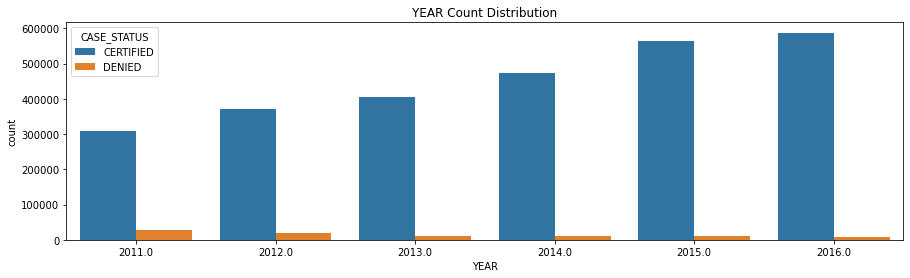

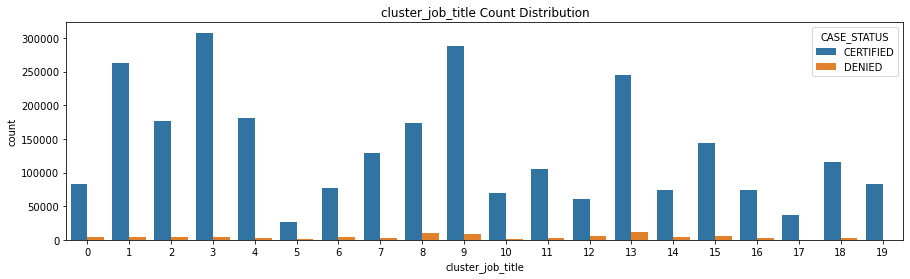

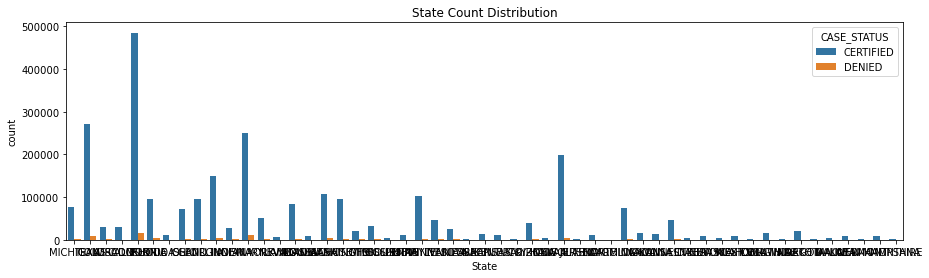

In [60]:
obj_col = np.array(['FULL_TIME_POSITION','YEAR','cluster_job_title','State'])

# add bar plot for each categorical variable, group by "y"
for i in range(0, len(obj_col)) :
    # set the plot size
    fig, ax = plt.subplots(figsize=(15,4))
    
    # use the countplot to group "y"
    sns.countplot(x = obj_col[i], hue='CASE_STATUS', data = df_after_clean)

    ax.set_title('{} Count Distribution'.format(obj_col[i]))

# Change the categorical data to cat.code

In [61]:
df.head()

,CASE_STATUS,EMPLOYER_NAME,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,cluster_job_title,SOC_NAME1,State
0,CERTIFIED,UNIVERSITY OF MICHIGAN,N,36067.0,2016.0,18,others,MICHIGAN
6,CERTIFIED,Others,Y,91021.0,2016.0,8,others,TEXAS
14,CERTIFIED,Others,Y,105914.0,2016.0,13,others,COLORADO
16,CERTIFIED,Others,Y,90834.0,2016.0,12,others,WISCONSIN
20,CERTIFIED,Others,Y,117998.0,2016.0,8,others,CALIFORNIA


In [62]:
# CASE_STATUS
df.CASE_STATUS = pd.Categorical(df.CASE_STATUS)
df['CASE_STATUS_code'] = df.CASE_STATUS.cat.codes
df_CASE_STATUS_code = df[['CASE_STATUS','CASE_STATUS_code']].drop_duplicates()
print(df_CASE_STATUS_code.shape)
print(df_CASE_STATUS_code.head())

df = df.drop(['CASE_STATUS'], axis = 1)

(2, 2)
   CASE_STATUS  CASE_STATUS_code
0    CERTIFIED                 0
91      DENIED                 1


In [63]:
# EMPLOYER_NAME
df.EMPLOYER_NAME = pd.Categorical(df.EMPLOYER_NAME)
df['EMPLOYER_NAME_code'] = df.EMPLOYER_NAME.cat.codes
df_EMPLOYER_NAME_code = df[['EMPLOYER_NAME','EMPLOYER_NAME_code']].drop_duplicates()
print(df_EMPLOYER_NAME_code.shape)
print(df_EMPLOYER_NAME_code.head())

df = df.drop(['EMPLOYER_NAME'], axis = 1)

(1001, 2)
                             EMPLOYER_NAME  EMPLOYER_NAME_code
0                   UNIVERSITY OF MICHIGAN                 915
6                                   Others                 621
298  UNIVERSITY OF CALIFORNIA, LOS ANGELES                 899
349              WAL-MART ASSOCIATES, INC.                 966
562               SUNERA TECHNOLOGIES, INC                 784


In [64]:
# FULL_TIME_POSITION
df.FULL_TIME_POSITION = pd.Categorical(df.FULL_TIME_POSITION)
df['FULL_TIME_POSITION_code'] = df.FULL_TIME_POSITION.cat.codes
df_FULL_TIME_POSITION_code = df[['FULL_TIME_POSITION','FULL_TIME_POSITION_code']].drop_duplicates()
print(df_FULL_TIME_POSITION_code.shape)
print(df_FULL_TIME_POSITION_code.head())

df = df.drop(['FULL_TIME_POSITION'], axis = 1)

(2, 2)
  FULL_TIME_POSITION  FULL_TIME_POSITION_code
0                  N                        0
6                  Y                        1


In [65]:
# YEAR
df.YEAR = pd.Categorical(df.YEAR)
df['YEAR_code'] = df.YEAR.cat.codes
df_YEAR_code = df[['YEAR','YEAR_code']].drop_duplicates()
print(df_YEAR_code.shape)
print(df_YEAR_code.head())

df = df.drop(['YEAR'], axis = 1)

(6, 2)
           YEAR  YEAR_code
0        2016.0          5
647804   2015.0          4
1266530  2014.0          3
1785958  2013.0          2
2228071  2012.0          1


In [67]:
# SOC_NAME1
df.SOC_NAME1 = pd.Categorical(df.SOC_NAME1)
df['SOC_NAME1_code'] = df.SOC_NAME1.cat.codes
df_SOC_NAME1_code = df[['SOC_NAME1','SOC_NAME1_code']].drop_duplicates()
print(df_SOC_NAME1_code.shape)
print(df_SOC_NAME1_code.head())

df = df.drop(['SOC_NAME1'], axis = 1)

(16, 2)
        SOC_NAME1  SOC_NAME1_code
0          others              13
17398     manager              10
647797   engineer               5
818137   research              14
1267324   analyst               1


In [68]:
# State
df.State = pd.Categorical(df.State)
df['state_code'] = df.State.cat.codes
df_state_code = df[['State','state_code']].drop_duplicates()
print(df_state_code.shape)
print(df_state_code.head())

df = df.drop(['State'], axis = 1)

(53, 2)
         State  state_code
0     MICHIGAN          22
6        TEXAS          45
14    COLORADO           5
16   WISCONSIN          51
20  CALIFORNIA           4


In [69]:
df.head()

,PREVAILING_WAGE,cluster_job_title,CASE_STATUS_code,EMPLOYER_NAME_code,FULL_TIME_POSITION_code,YEAR_code,SOC_NAME1_code,state_code
0,36067.0,18,0,915,0,5,13,22
6,91021.0,8,0,621,1,5,13,45
14,105914.0,13,0,621,1,5,13,5
16,90834.0,12,0,621,1,5,13,51
20,117998.0,8,0,621,1,5,13,4


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2799076 entries, 0 to 3002212
Data columns (total 8 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   PREVAILING_WAGE          float64
 1   cluster_job_title        int32  
 2   CASE_STATUS_code         int8   
 3   EMPLOYER_NAME_code       int16  
 4   FULL_TIME_POSITION_code  int8   
 5   YEAR_code                int8   
 6   SOC_NAME1_code           int8   
 7   state_code               int8   
dtypes: float64(1), int16(1), int32(1), int8(5)
memory usage: 72.1 MB


In [71]:
# to csv 
df.to_csv('Clean_H1B_data.csv', index=False)

### Job_title- another way, but not preferred

In [275]:
titles = pd.Series(df['JOB_TITLE'].unique())[:300]
titles.head(20)

0                          POSTDOCTORAL RESEARCH FELLOW
1                               CHIEF OPERATING OFFICER
2                                 CHIEF PROCESS OFFICER
3                           REGIONAL PRESIDEN, AMERICAS
4     EXECUTIVE V P, GLOBAL DEVELOPMENT AND PRESIDEN...
5                              CHIEF OPERATIONS OFFICER
6                                             PRESIDENT
7        CHIEF INFORMATION OFFICER, HEINZ NORTH AMERICA
8      VICE PRESIDENT AND CHIEF HUMAN RESOURCES OFFICER
9                                     TREASURER AND COO
10                             CHIEF COMMERCIAL OFFICER
11                                         BOARD MEMBER
12                              CHIEF FINANCIAL OFFICER
13                            VICE PRESIDENT OF FINANCE
14                          GENERAL MANAGER, OPERATIONS
15                                                  CEO
16                          PRESIDENT, NORTHEAST REGION
17                        CHIEF OPERATING OFFICE

In [276]:
#Convert all titles to lower case
titles = titles.apply(lambda x: x.lower())

In [279]:
lev_similarity = -1 * np.array([[distance.levenshtein(j1,j2) for j1 in titles] for j2 in titles])

In [280]:
lev_similarity

array([[  0, -25, -24, ..., -32, -29, -22],
       [-25,   0,  -7, ..., -30, -32, -17],
       [-24,  -7,   0, ..., -35, -33, -16],
       ...,
       [-32, -30, -35, ...,   0, -38, -38],
       [-29, -32, -33, ..., -38,   0, -35],
       [-22, -17, -16, ..., -38, -35,   0]])

In [290]:
lev_similarity.shape

(300, 300)

In [281]:
affprop = sklearn.cluster.AffinityPropagation(affinity="precomputed", damping = 0.5)
affprop.fit(lev_similarity)

AffinityPropagation(affinity='precomputed')

In [282]:
def orderClusters(array):    
    clusters = pd.Series()    
    for cluster_id in np.unique(affprop.labels_):
        exemplar = array[affprop.cluster_centers_indices_[cluster_id]]
        cluster = np.unique(array[affprop.labels_==cluster_id])
        if exemplar not in clusters:
            clusters[exemplar] = cluster            
    return clusters

In [284]:
clusters = orderClusters(titles)

counter = 0
for key in clusters.keys():
    print (key , ': ' , clusters[key])
    counter += 1
    if counter >= 10:
        break

chief operating officer :  ['cheif marketing officer' 'chief analytics officer' 'chief brand officer'
 'chief commercial officer' 'chief finanacial officer'
 'chief financial officer' 'chief information officer'
 'chief management officer' 'chief marketing officer'
 'chief operating officer' 'chief operating officer (coo)'
 'chief operating officer - americas'
 'chief operating officer, it infrastructure' 'chief operations officer'
 'chief process officer' 'chief product officer' 'chief risk officer'
 'chief strategy officer' 'chief sustainability officer'
 'chief technology officer' 'evp & chief development officer'
 'global chief operating officer']
executive v p, global development and president, latin ameri :  ['executive v p, global development and president, latin ameri']
chief information officer, heinz north america :  ['chief information officer, business unit it services'
 'chief information officer, heinz north america'
 'chief innovation officer & senior vp of clinical syst

In [293]:
affprop = sklearn.cluster.AffinityPropagation(affinity="precomputed", damping = 0.5, preference = -50)
affprop.fit(lev_similarity)
clusters = orderClusters(titles)
len(clusters)

18

In [294]:
counter = 0
for key in clusters.keys():
    print (key , ': ' , clusters[key])
    counter += 1
    if counter >= 10:
        break

chief operating officer :  ['ceo, executive chairman' 'cheif executive officer'
 'cheif marketing officer' 'chief analytics officer' 'chief brand officer'
 'chief business officer' 'chief commercial officer'
 'chief creative officer' 'chief executive officer'
 'chief finanacial officer' 'chief financial officer'
 'chief information officer' 'chief management officer'
 'chief marketing officer' 'chief medical information officer'
 'chief medical officer' 'chief operating officer'
 'chief operating officer (coo)' 'chief operating officer - americas'
 'chief operating officer, it infrastructure' 'chief operations officer'
 'chief people and culture officer' 'chief process officer'
 'chief product officer' 'chief risk officer' 'chief scientific officer'
 'chief strategy officer' 'chief sustainability officer'
 'chief technical officer' 'chief technology officer'
 'evp & chief development officer'
 'global chief human resources & strategy officer'
 'global chief operating officer' 'group ch

In [296]:
clusters.keys()

Index(['chief operating officer', 'general manager, operations',
       'vice president of operations', 'vice president',
       'executive vice president, brand development',
       'president and chief executive officer',
       'senior vice president of operations',
       'vice president of business development',
       'director, operations research', 'director, business development',
       'managing director', 'business development director',
       'president and ceo', 'vice president, sales & marketing',
       'chief information officer, business unit it services',
       'chief executive officer & president', 'general & operations manager',
       'product manager'],
      dtype='object')

In [323]:
clusters

chief operating officer                                 [ceo, executive chairman, cheif executive offi...
general manager, operations                             [assistant general counsel, chief of staff, as...
vice president of operations                            [full-time chairman of the board, group presid...
vice president                                          [assistant vice president, ceo, ceo/chairman, ...
executive vice president, brand development             [executive chairman, stewart & stevenson power...
president and chief executive officer                   [chairman and chief executive officer, electri...
senior vice president of operations                     [asso. vice chancellor for intel. prop. and in...
vice president of business development                  [assistant vice president, business developmen...
director, operations research                           [area coach operations-in training, associate ...
director, business development                

In [286]:
affprop = sklearn.cluster.AffinityPropagation(affinity="precomputed", damping = 0.5, preference = -3)
affprop.fit(lev_similarity)
clusters = orderClusters(titles)
len(clusters)

280

In [287]:
clusters = orderClusters(titles)

for key in clusters.keys():
    if len(clusters[key]) >= 2:
        print (key , ': ' , clusters[key])

chief operations officer :  ['chief operating officer' 'chief operations officer']
chief financial officer :  ['chief finanacial officer' 'chief financial officer']
ceo :  ['ceo' 'coo']
vice president of engineering :  ['vice president engineering' 'vice president of engineering']
vice president, business development :  ['vice president of business development'
 'vice president, business development']
president & chief executive officer :  ['president & chief executive officer' 'president/chief executive officer']
senior vice president of operations :  ['senior vice president - operations'
 'senior vice president of operations']
vp marketing (import/export) :  ['vp marketing (import/export' 'vp marketing (import/export)']
vice president, finance :  ['vice president of finance' 'vice president, finance']
chief marketing officer :  ['cheif marketing officer' 'chief marketing officer']
chief executive :  ['chief ececutive' 'chief executive' 'chief executives']
cheif executive officer :  [

In [291]:
clusters.keys()

Index(['postdoctoral research fellow', 'chief process officer',
       'regional presiden, americas',
       'executive v p, global development and president, latin ameri',
       'chief operations officer', 'president',
       'chief information officer, heinz north america',
       'vice president and chief human resources officer', 'treasurer and coo',
       'chief commercial officer',
       ...
       'director of bank card sales', 'research coordinator',
       'manager operations & business development',
       'senior manager, profitability management',
       'manager, crane business systems',
       'patient strategies & operations analyst',
       'corporate development manager- legal advisor',
       'director of operations & product development',
       'assistant general counsel, chief of staff', 'country manager'],
      dtype='object', length=280)